In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
from itertools import product

In [2]:
from codecarbon import EmissionsTracker

codecarbon_output = "./codecarbon_emissions_Vila_Militar.csv"

In [3]:
df = pd.read_csv('Interpolado_VilaMilitar.csv', sep=',')
df

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",datetime
0,0.0,1013.6,1014.0,1013.5,1668.5,22.9,20.5,31.0,29.3,21.0,19.4,57.0,52.0,54.0,127.0,8.4,0.8,2007-04-13 16:00:00
1,0.0,1013.2,1013.6,1013.2,1002.6,22.9,20.5,30.6,29.1,21.7,20.2,65.0,54.0,65.0,155.0,6.8,3.0,2007-04-13 17:00:00
2,0.0,1013.2,1013.2,1013.0,561.0,22.9,20.5,29.3,28.7,21.9,20.6,66.0,61.0,62.0,151.0,6.8,3.0,2007-04-13 18:00:00
3,0.0,1013.6,1013.6,1013.2,261.5,22.9,20.5,28.8,28.2,21.5,20.3,66.0,62.0,63.0,168.0,6.3,2.8,2007-04-13 19:00:00
4,0.0,1014.3,1014.3,1013.6,48.7,22.9,20.5,28.4,27.4,21.2,20.1,69.0,62.0,69.0,190.0,6.3,1.5,2007-04-13 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155331,0.0,1008.9,1009.2,1008.5,2204.9,28.0,20.8,29.4,28.0,21.9,20.6,67.0,62.0,65.0,244.0,10.4,3.2,2024-12-31 19:00:00
155332,0.0,1008.5,1009.1,1008.5,714.1,26.5,20.7,28.0,26.5,21.1,20.0,72.0,64.0,71.0,255.0,9.4,3.5,2024-12-31 20:00:00
155333,0.0,1009.5,1009.5,1008.5,188.5,25.8,20.6,26.5,25.8,20.8,20.1,73.0,70.0,73.0,227.0,9.4,0.9,2024-12-31 21:00:00
155334,0.0,1009.5,1009.7,1009.5,21.8,25.6,20.0,26.0,25.6,20.6,20.0,73.0,70.0,71.0,224.0,4.4,0.8,2024-12-31 22:00:00


Partição precipitação, temperatura e umidade, respectivamente

In [4]:
X_prec = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_prec = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']

In [5]:
X_temp = df[[
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_temp = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

In [6]:
X_umid = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_umid = df['UMIDADE RELATIVA DO AR, HORARIA (%)']

Funções

In [7]:
def split_train_test(X, y, train_size):
    X_train, X_test = X[:round(X.shape[0]*train_size)], X[round(X.shape[0]*train_size):]
    y_train, y_test = y[:round(y.shape[0]*train_size)], y[round(y.shape[0]*train_size):]

    return X_train, X_test, y_train, y_test

def train_xgboost(X_train, y_train, X_test, y_test, params):
    xgb_model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)
    
    predictions = xgb_model.predict(xgb.DMatrix(X_test))
    
    rmse = mean_squared_error(y_test, predictions)
    
    return xgb_model, predictions
    
def grid_search_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    param_combinations = list(product(
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['subsample'],
        param_grid['colsample_bytree'],
        param_grid['min_child_weight']
    ))
    
    best_rmse = float('inf')
    best_params = None

    for combination in tqdm(param_combinations, desc="Grid Search Progress"):
        max_depth, learning_rate, subsample, colsample_bytree, min_child_weight = combination
        params = {
            'max_depth': max_depth,
            'eta': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        
        model, predictions = train_xgboost(X_train, y_train, X_test, y_test, params)
        rmse = mean_squared_error(y_test, predictions)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    
    print("Best parameters found:")
    print(best_params)
    print(f"Best RMSE: {best_rmse}")
    
    final_model, final_predictions = train_xgboost(X_train, y_train, X_test, y_test, best_params)
    
    return final_model, final_predictions, best_params

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MRSE: {np.sqrt(mean_squared_error(y_test, prediction))}")

def plot_real_vs_predicted(y_test, predictions, save=False):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)

    if save: 
        plt.savefig(save)
    
    plt.show()

def plot_prediction_over_time(y_test, predictions, timestamps, start_date=None, end_date=None, save=False):
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_test,
        'Predicted': predictions
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)

    
    if save: 
        plt.savefig(save)
        
    plt.show()

In [8]:
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["datetime"]

In [ ]:
Precipitação xgboost

In [9]:
X_train, X_test, y_train, y_test = split_train_test(X_prec, y_prec, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost precipiptation train 0.8",
    output_file='./codecarbon_emissions_VilaMilitar.csv',
    log_level = "critical"
)

tracker.start()

prec_model, prec_predictions, prec_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 22:29:38] Multiple instances of codecarbon are allowed to run at the same time.
Grid Search Progress: 100%|██████████| 243/243 [04:40<00:00,  1.15s/it]


Best parameters found:
{'max_depth': 4, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 1.11725502695741
emissions=2.2636041133167464e-05


In [10]:
evaluate_model(y_test, prec_predictions)

MAE: 0.21982758929486884
MSE: 1.11725502695741
MRSE: 1.057002850969386


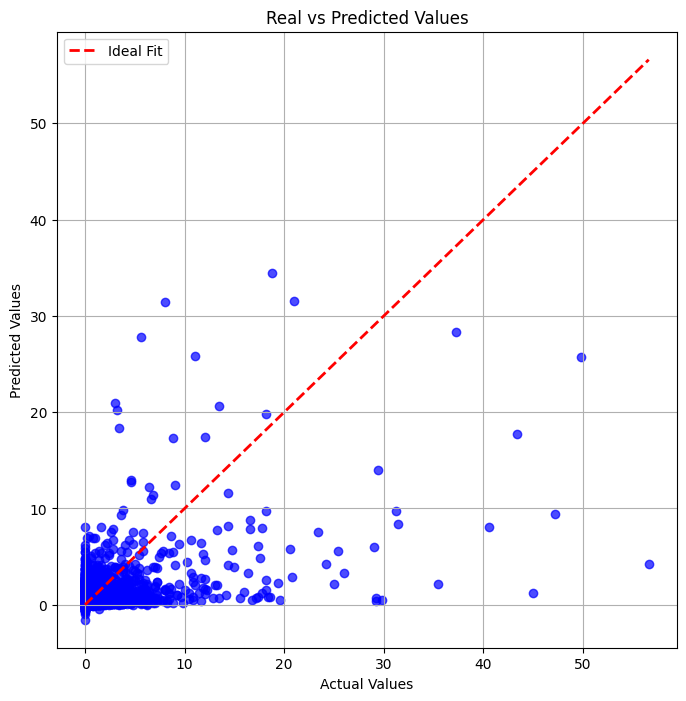

In [11]:
plot_real_vs_predicted(y_test, prec_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_prec_real_geral_VilaMilitar.png')


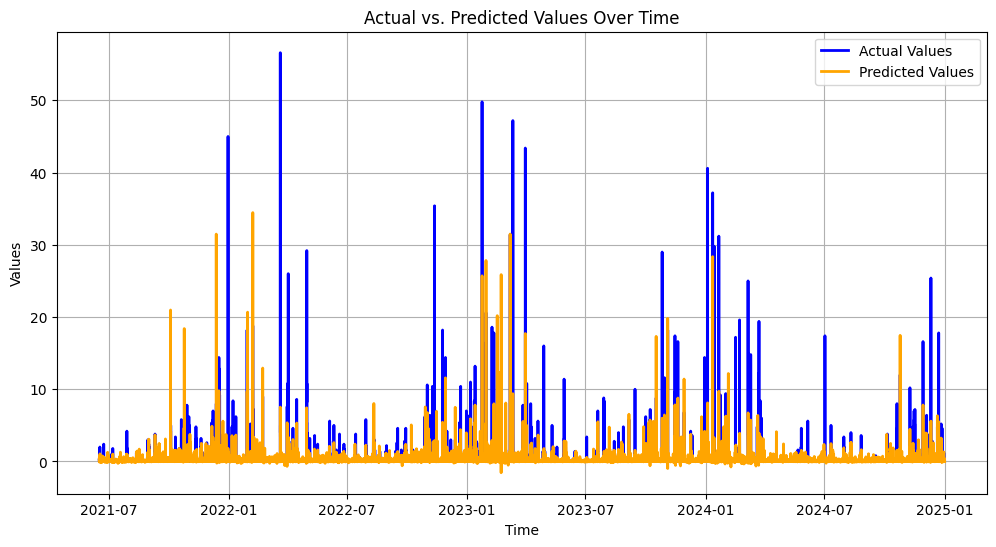

In [12]:
plot_prediction_over_time(y_test, prec_predictions, timestamps_test)


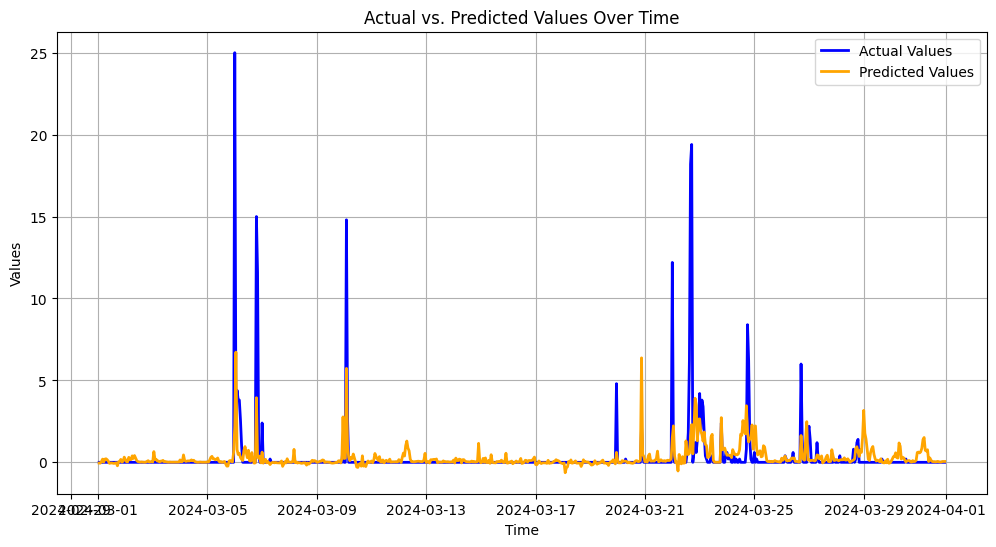

In [13]:
start_date = "2024-03-01 01:00:00"
end_date = "2024-03-31 23:00:00"

plot_prediction_over_time(y_test, prec_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_prec_real_03-2024_VilaMilitar.png')

Temperatura xgboost

In [14]:
X_train, X_test, y_train, y_test = split_train_test(X_temp, y_temp, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost temperature train 0.8",
    output_file='./codecarbon_emissions_VilaMilitar.csv',
    log_level = "critical"
)

tracker.start()

temp_model, temp_predictions, temp_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [06:15<00:00,  1.55s/it]


Best parameters found:
{'max_depth': 6, 'eta': 0.2, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 4.525017946924231
emissions=3.0439768081936264e-05


In [15]:
evaluate_model(y_test, temp_predictions)

MAE: 1.6661643550934069
MSE: 4.525017946924231
MRSE: 2.1272089570430617


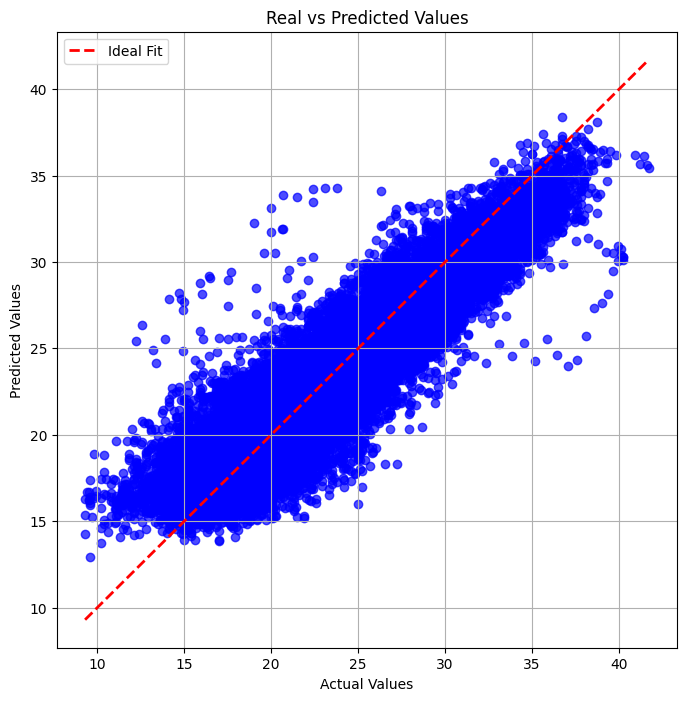

In [16]:
plot_real_vs_predicted(y_test, temp_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_temp_real_geral_VilaMilitar.png')


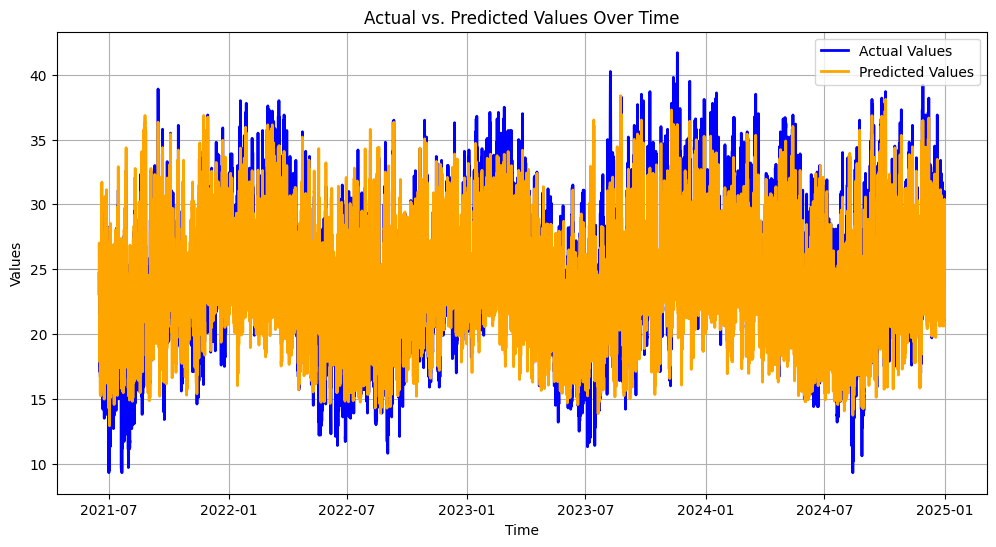

In [17]:
plot_prediction_over_time(y_test, temp_predictions, timestamps_test)

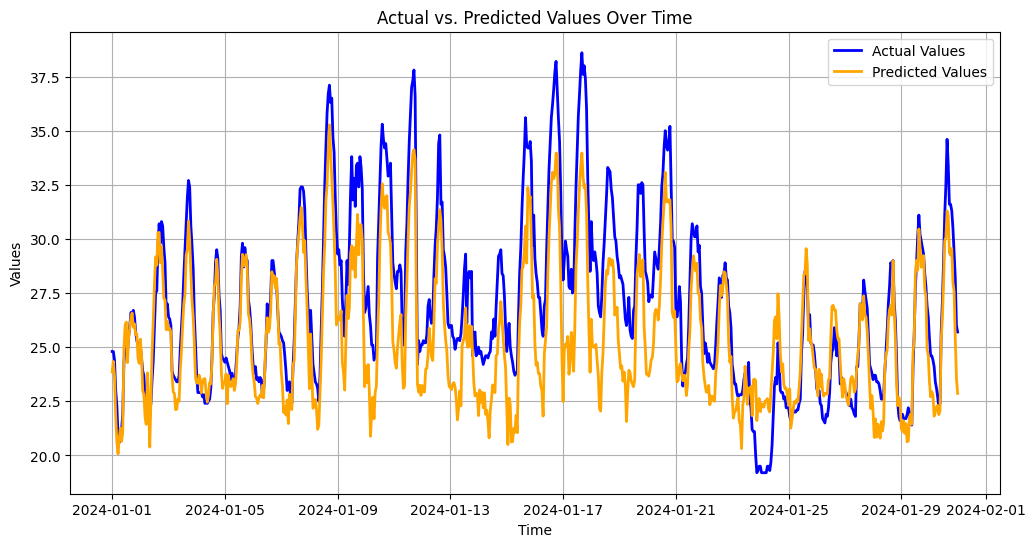

In [18]:
start_date = "2024-01-01"
end_date = "2024-01-31"

plot_prediction_over_time(y_test, temp_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_temp_real_2024-01_VilaMilitar.png')

In [ ]:
Umidade xgboost

In [19]:
X_train, X_test, y_train, y_test = split_train_test(X_umid, y_umid, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost umidity train 0.8",
    output_file='./codecarbon_emissions_VilaMilitar.csv',
    log_level = "critical"
)

tracker.start()

umid_model, umid_predictions, umid_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [04:11<00:00,  1.04s/it]


Best parameters found:
{'max_depth': 8, 'eta': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 14.50766411815879
emissions=2.039992002607875e-05


In [20]:
evaluate_model(y_test, umid_predictions)

MAE: 1.331170688364701
MSE: 14.50766411815879
MRSE: 3.8088927680047373


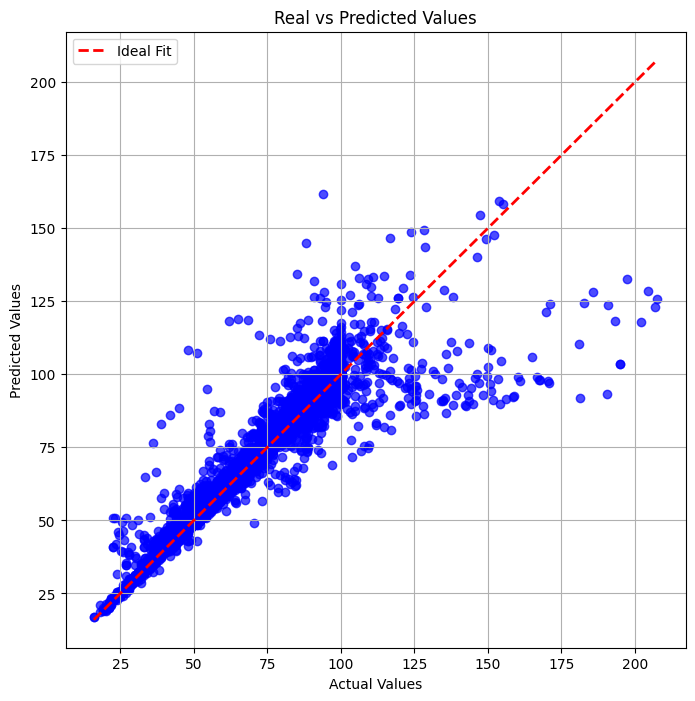

In [21]:
plot_real_vs_predicted(y_test, umid_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_umid_real_geral_VilaMilitar.png')


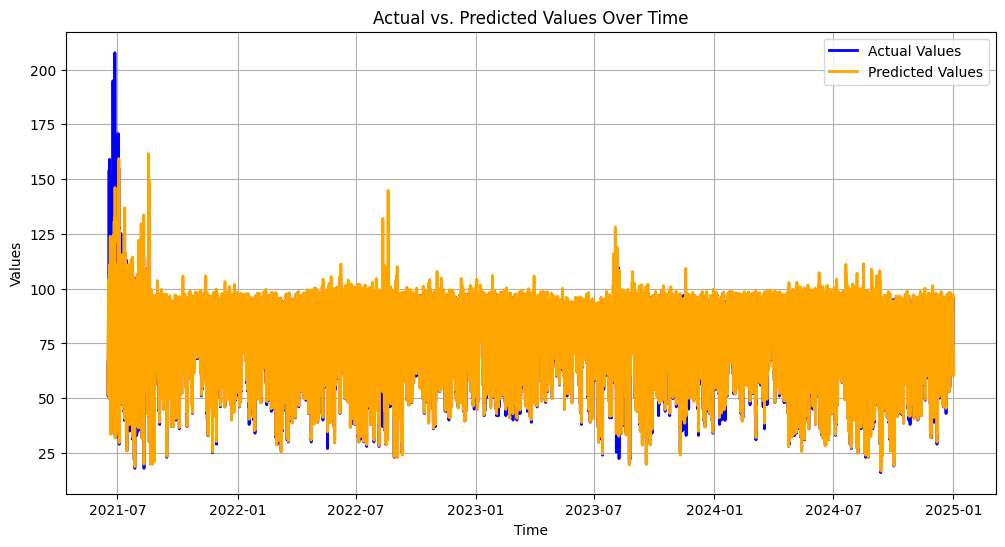

In [22]:
plot_prediction_over_time(y_test, umid_predictions, timestamps_test)

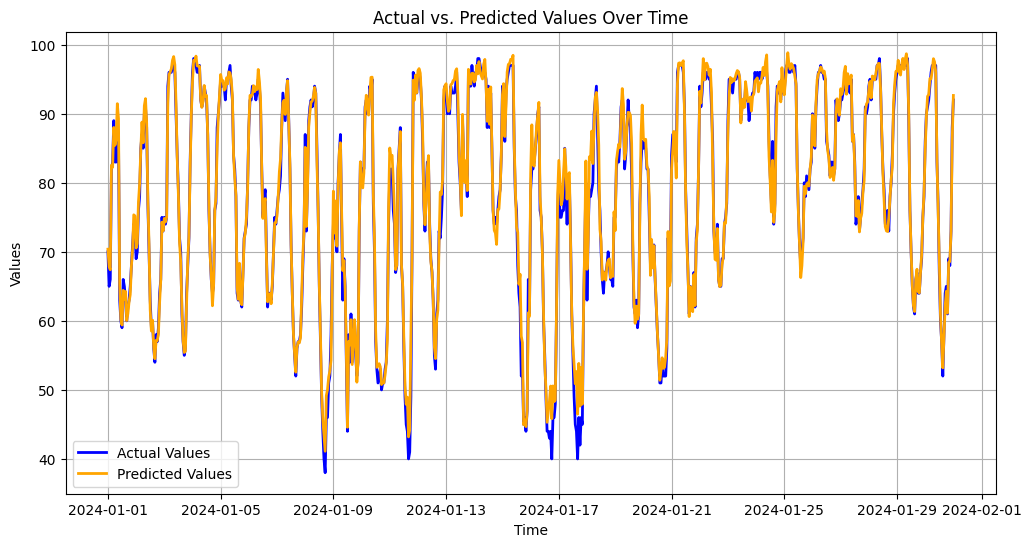

In [24]:
start_date = "2024-01-01"
end_date = "2024-01-31"

plot_prediction_over_time(y_test, umid_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_umid_real_2024-01_Marambaia.png')